In [26]:
import matplotlib.pyplot as plt
import json
import imp
import sys
sys.path.insert(1,'./tools')
import utils
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn import metrics


## Reproduce DL result

In [2]:
hpara_dict_path = './nn_codes/exp/best_clinical_bert/hpara.json'
trained_word_model = './nn_codes/exp/best_clinical_bert/save_word_10.bin' 
trained_sent_model = './nn_codes/exp/best_clinical_bert/save_sent_10.bin' 

In [3]:
imp.reload(utils)
hpara1,tokenizer,model_word, model_sent = utils.define_model(hpara_dict_path,trained_word_model,trained_sent_model)

In [4]:
import pickle
src_dir = './preprocessing/result/ratio2/'
text_test  = pickle.load(open(src_dir+'merged_text_test.pkl','rb')) 
label_test = pickle.load(open(src_dir+'label_test.pkl','rb'))
params_all = {'batch_size': 1,
    'shuffle': False,
    'num_workers': 6}
validation_set = utils.DocDataset(text_test, label_test)
validation_generator = DataLoader(validation_set, **params_all)

In [5]:
save_dir = './plot'
output_generator = utils.output_att_scores(hpara1,model_word,model_sent,save_dir,\
                       validation_generator,tokenizer)

In [6]:
%%time
pred_matrix = np.zeros([len(label_test),2])
for i,(_,sent_att_output,doc,proba,label) in enumerate(output_generator):
    proba = proba.cpu().detach().numpy()
    pred_matrix[i] = proba

CPU times: user 4min 43s, sys: 805 ms, total: 4min 44s
Wall time: 1min 14s


In [11]:
pred_matrix

array([[0.98558229, 0.01441759],
       [0.74534684, 0.25465319],
       [0.96796882, 0.03203113],
       ...,
       [0.99017018, 0.00982983],
       [0.98313218, 0.01686782],
       [0.99281484, 0.00718502]])

In [12]:
pos_proba = pred_matrix[:,1]

In [33]:
roc_auc_score(label_test, pos_proba)

0.9588340335228301

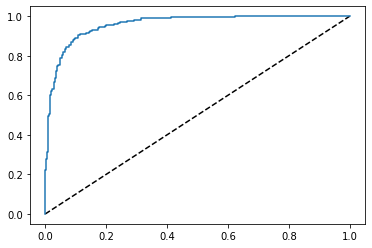

In [13]:
bert_fpr, bert_tpr, bert_thresholds = roc_curve(label_test, pos_proba, pos_label=1)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(bert_fpr, bert_tpr, label='Bert')

## Reproduce ML result

In [17]:
from joblib import dump, load
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer


In [21]:
src_dir = './preprocessing/result/ratio2/'
label_test = pickle.load(open(src_dir+'label_test.pkl','rb'))
label_train = pickle.load(open(src_dir+'label_train.pkl','rb'))
new_text_train = pickle.load(open(src_dir + 'text_train_lemma.pkl','rb'))
new_text_test = pickle.load(open(src_dir + 'text_test_lemma.pkl','rb'))

In [22]:
Tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df =5,stop_words='english',max_df = 0.8)
X_train = Tfidf_vectorizer.fit_transform(new_text_train)
Y_train = label_train
X_test = Tfidf_vectorizer.transform(new_text_test)
Y_test = label_test
print(np.shape(X_train))

(2887, 83475)


In [31]:
SVC_clf = load('./PU_classifier_training/py37_SVC_clf_12gram.joblib')
y_pred = SVC_clf.predict(X_test)
y_pred_proba = SVC_clf.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba,axis=-1)
print(metrics.classification_report(Y_test, y_pred, target_names=['No_infection','infection']))
print(metrics.confusion_matrix(Y_test,y_pred))
print(metrics.roc_auc_score(Y_test, y_pred))

              precision    recall  f1-score   support

No_infection       0.89      0.94      0.91       481
   infection       0.86      0.77      0.81       241

    accuracy                           0.88       722
   macro avg       0.88      0.85      0.86       722
weighted avg       0.88      0.88      0.88       722

[[451  30]
 [ 56 185]]
0.852632396200861


In [ ]:
SVC_clf = svm.SVC(class_weight = 'balanced',kernel = 'linear',probability=1)
SVC_clf.fit(X_train, Y_train)
y_pred = SVC_clf.predict(X_test)

y_pred_proba = SVC_clf.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba,axis=-1)
dump(SVC_clf, './PU_classifier_training/py37_SVC_clf_12gram.joblib')
print(metrics.classification_report(Y_test, y_pred, target_names=['No_infection','infection']))
print(metrics.confusion_matrix(Y_test,y_pred))
print(metrics.roc_auc_score(Y_test, y_pred))

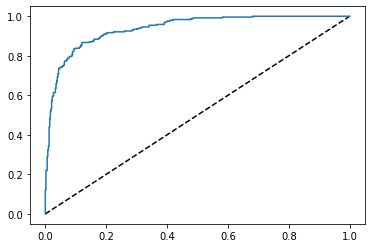

In [40]:
svm_fpr, svm_tpr, svm_thresholds = roc_curve(Y_test, y_pred_proba[:,1], pos_label=1)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(svm_fpr, svm_tpr, label='svm')

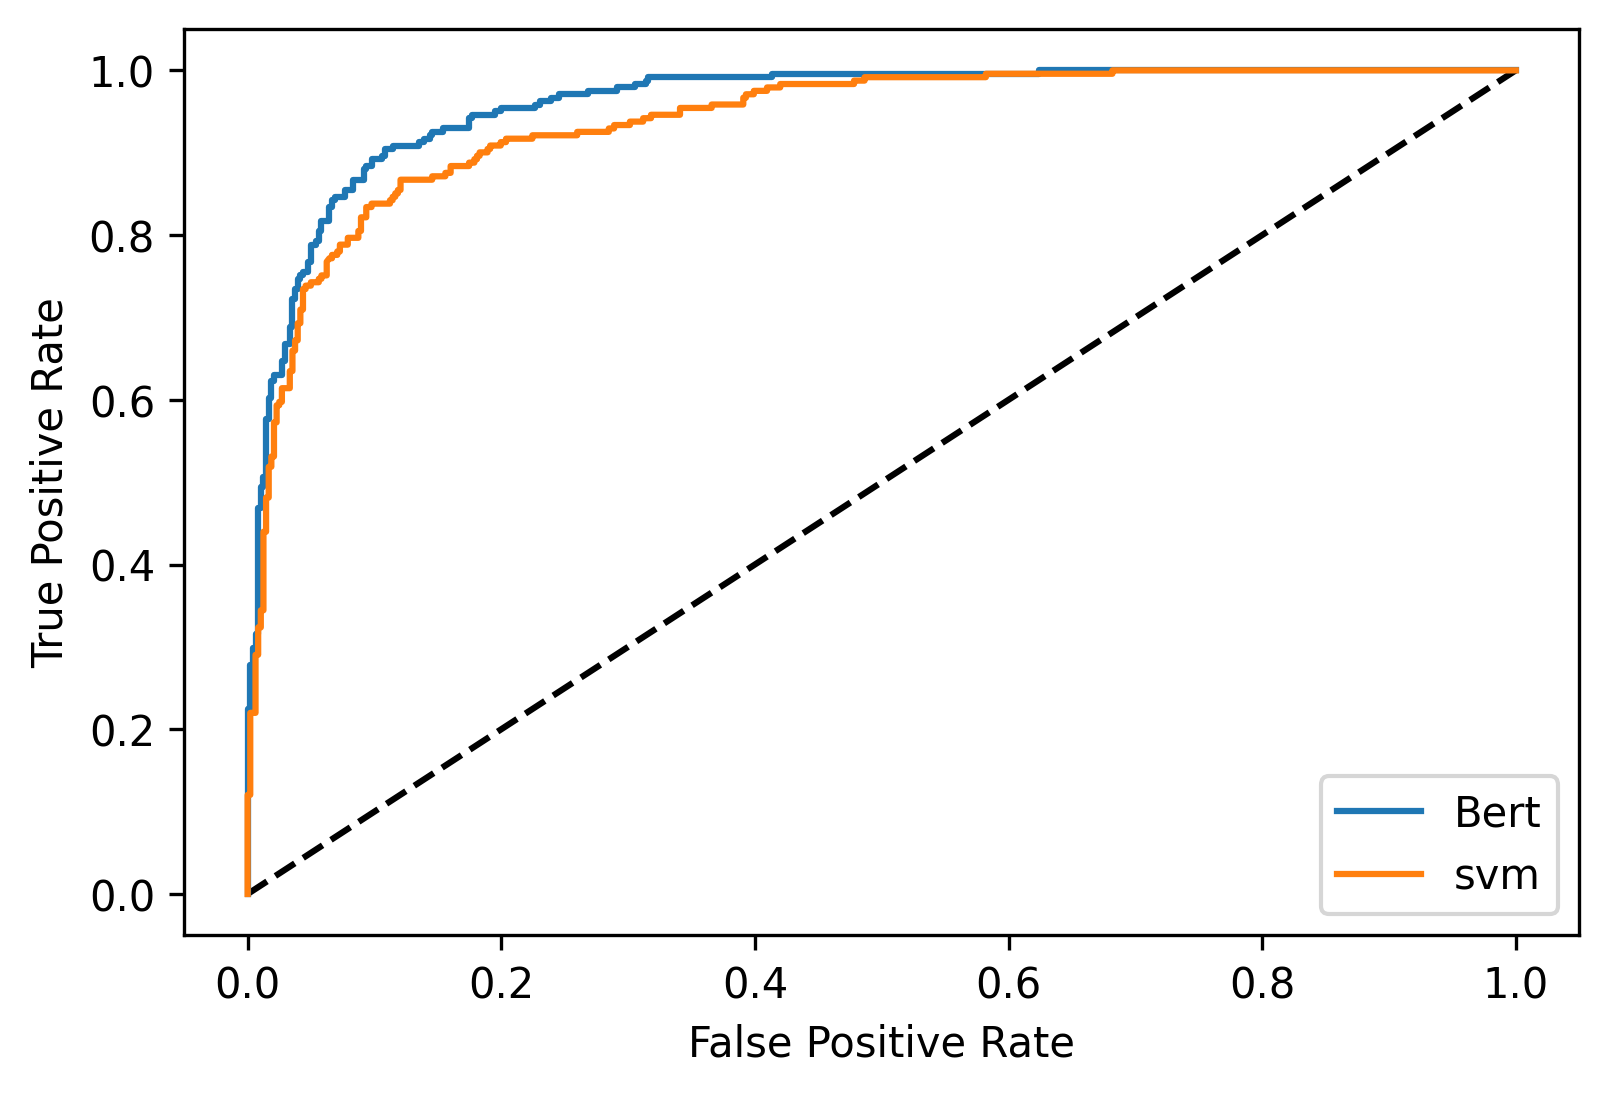

In [137]:
plt.figure(1,dpi=300)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(bert_fpr, bert_tpr, label='Bert')
plt.plot(svm_fpr, svm_tpr, label='svm')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [138]:
imp.reload(utils)
optimal_point,f1_list = utils.f1_maximize(y_pred_proba[:,1],Y_test)

[[436  45]
 [ 40 201]]


In [139]:
optimal_point

{'max_f1': 0.8254619784204527,
 'precision': 0.8170731375173521,
 'recall': 0.8340248616587195,
 'thres': 0.37}

In [140]:
Y_test == 0

False

In [141]:
neg_ind =  np.where(np.array(Y_test) == 0)[0]
fp = np.sum(y_pred_proba[neg_ind,1] > optimal_point['thres'])
fp_ratio = fp / len(neg_ind)
print(fp_ratio)

0.09355509355509356


In [142]:
1-fp_ratio

0.9064449064449065

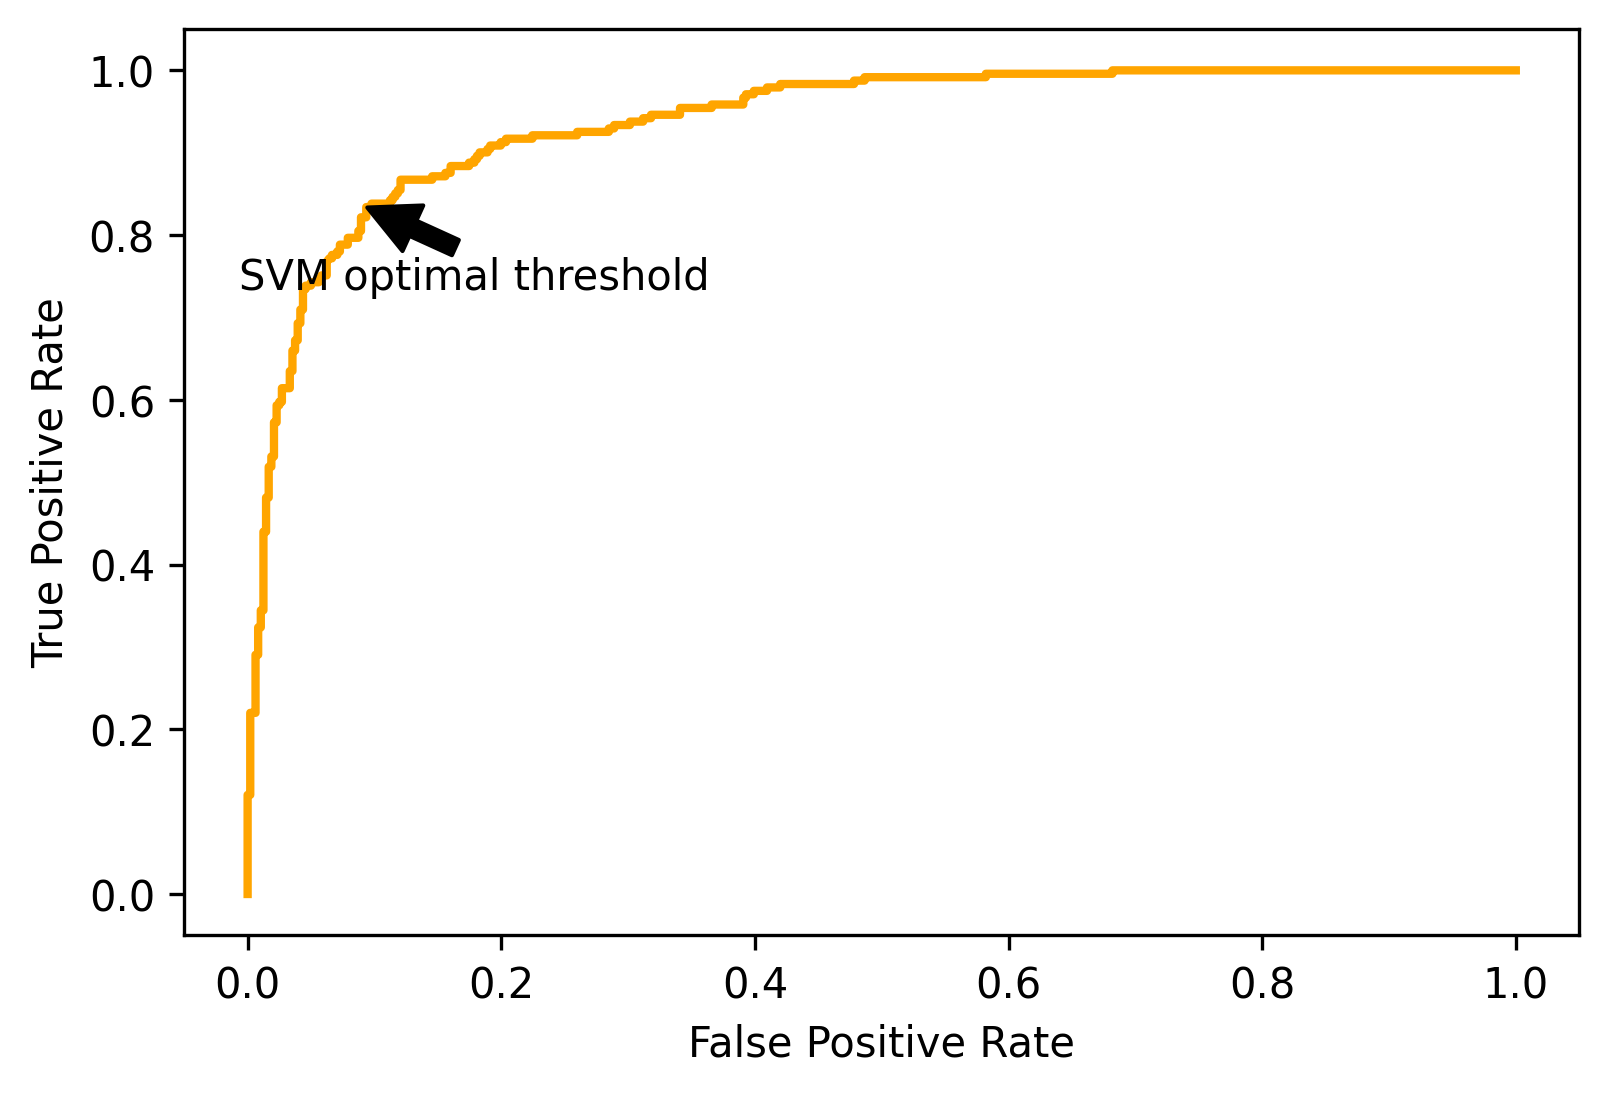

In [143]:
fig, ax = plt.subplots(dpi=300)
line, = ax.plot(svm_fpr, svm_tpr, lw=2,color='orange')
ax.annotate('SVM optimal threshold', xy=(fp_ratio, optimal_point['recall']), xytext=(fp_ratio-0.1, optimal_point['recall']-0.1),
            arrowprops=dict(facecolor='black', shrink=0.01),
            )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

'max_f1': 0.8254619784204527,
'precision': 0.8170731375173521,
'recall': 0.8340248616587195,
'specificity': 0.9064449064449065
'thres': 0.37
'AUC_socre':0.852632396200861

In [144]:
optimal_point,f1_list = utils.f1_maximize(pos_proba,label_test)
optimal_point

[[434  47]
 [ 26 215]]


./tools/utils.py:532: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * precision * recall / (precision + recall)


{'max_f1': 0.8548707413570281,
 'precision': 0.8206106557018834,
 'recall': 0.8921161455553467,
 'thres': 0.64}

In [145]:
neg_ind =  np.where(np.array(label_test) == 0)[0]
fp = np.sum(pos_proba[neg_ind] > optimal_point['thres'])
fp_ratio = fp / len(neg_ind)
print(fp_ratio)

0.09771309771309772


In [146]:
1- 0.09771309771309772


0.9022869022869022

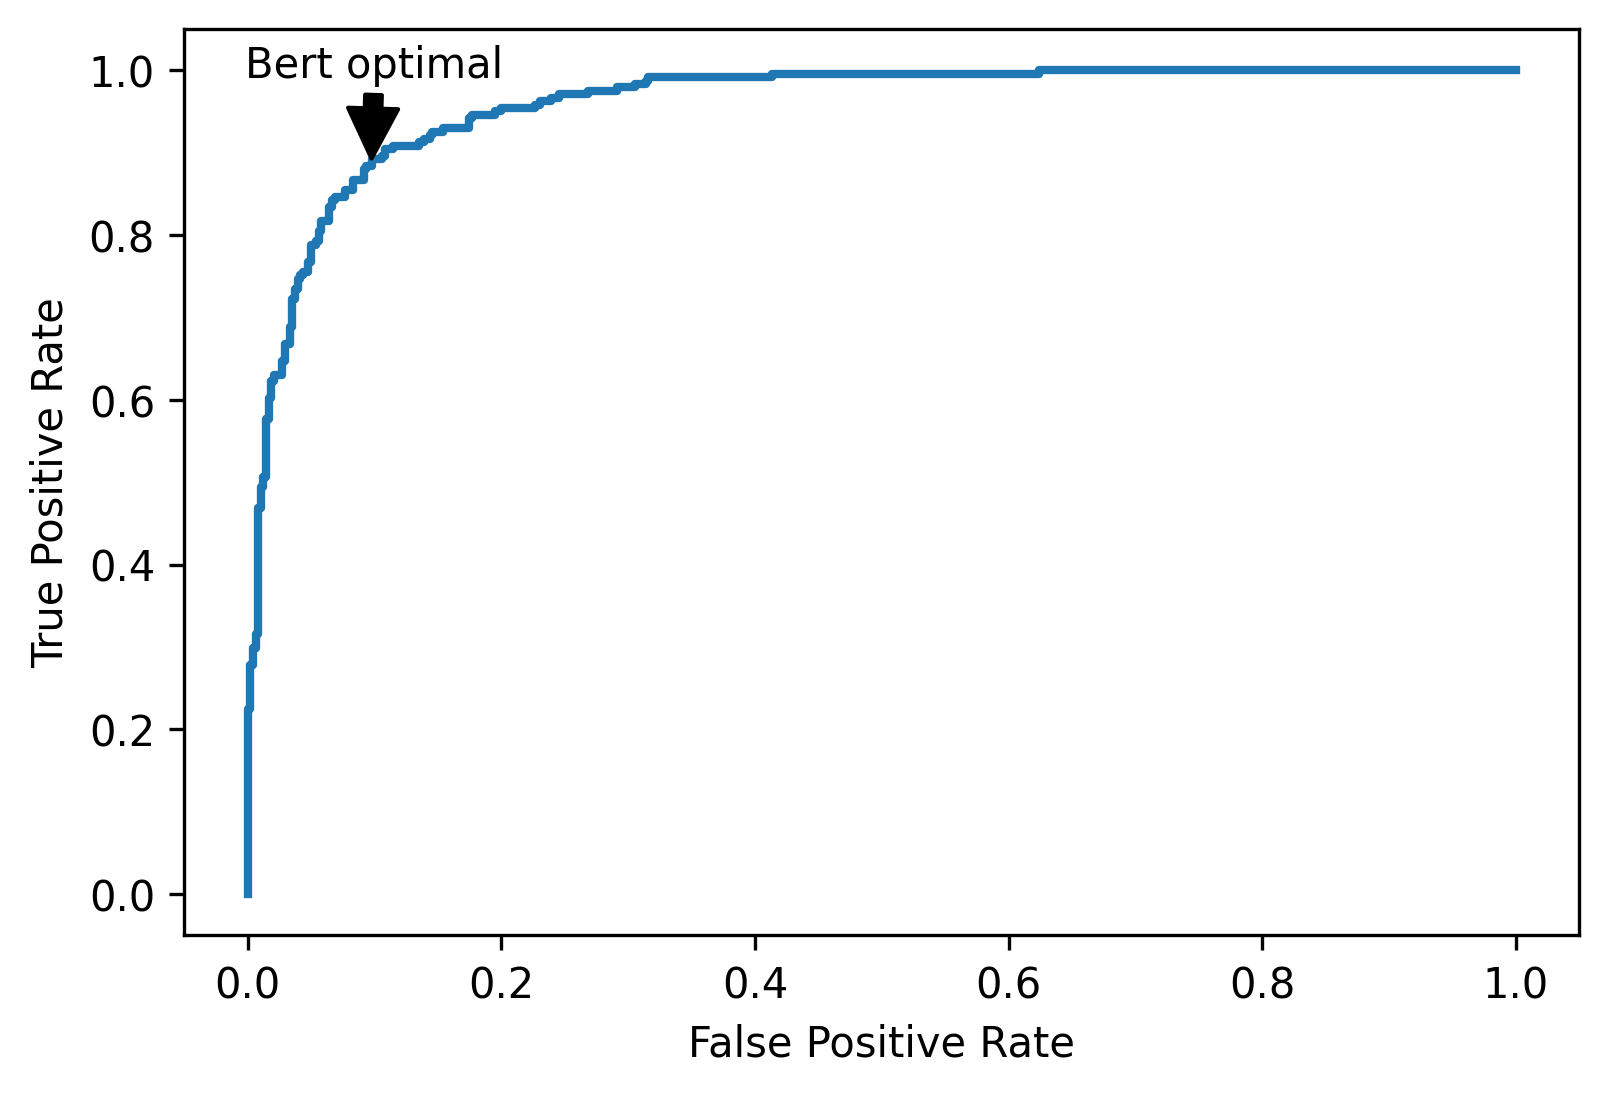

In [147]:
fig, ax = plt.subplots(dpi=300)
line, = ax.plot(bert_fpr, bert_tpr, lw=2)
ax.annotate('Bert optimal', xy=(fp_ratio, optimal_point['recall']), xytext=(fp_ratio-0.1, optimal_point['recall']+0.1),
            arrowprops=dict(facecolor='black', shrink=0.01),
            )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

'max_f1': 0.8548707413570281,
 'precision': 0.8206106557018834,
 'recall': 0.8921161455553467,
 'specificity': 0.9022869022869022
 'thres': 0.64
 'AUC_score':0.9588340335228301

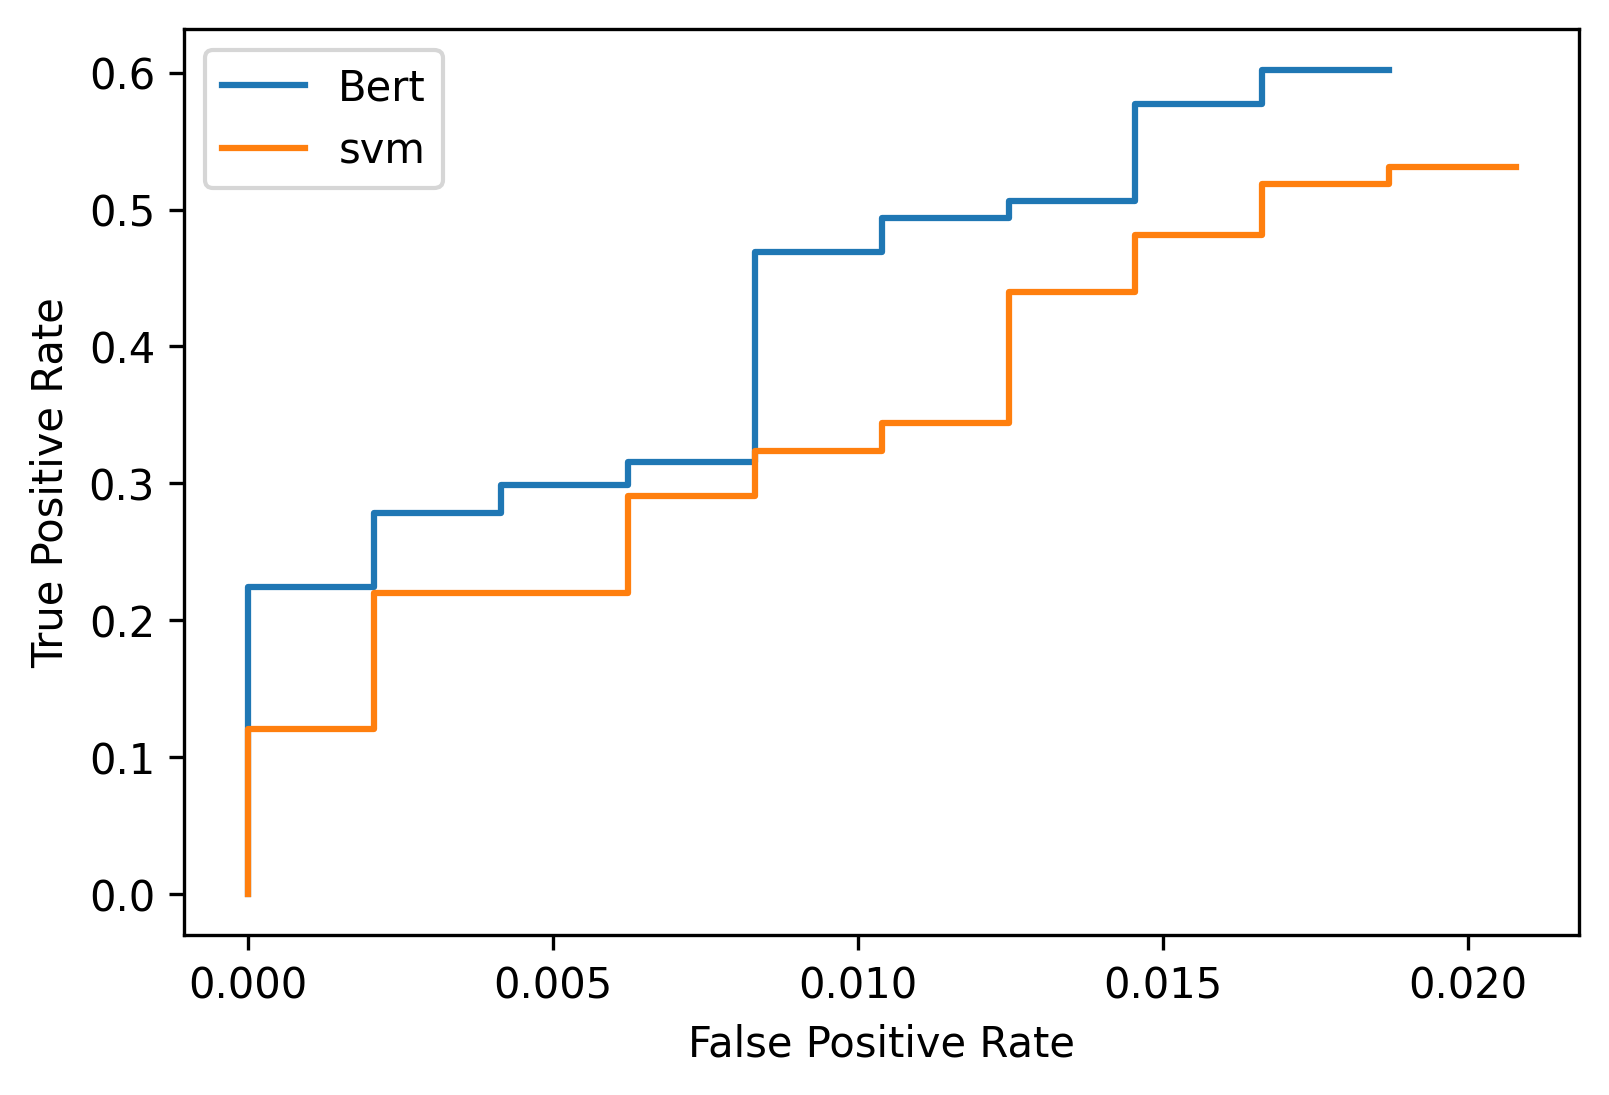

In [134]:
plt.figure(1,dpi=300)
plt.plot(bert_fpr[:20], bert_tpr[:20], label='Bert')
plt.plot(svm_fpr[:20], svm_tpr[:20], label='svm')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [54]:
 aaa = bert_tpr[:70] / bert_fpr[:70]

/home/zilong.zhang1/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/zilong.zhang1/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [56]:
aaa

array([         nan,          inf,          inf, 107.77593361,
       133.7219917 ,  66.86099585,  71.85062241,  47.90041494,
        50.5615491 ,  37.92116183,  56.38278008,  45.10622407,
        47.50124481,  39.58437068,  40.58229599,  34.78482513,
        39.63189093,  34.67790456,  36.17479253,  32.15537114,
        33.26417704,  29.93775934,  30.33692946,  23.33609959,
        23.95020747,  22.23947836,  22.95228216,  20.08324689,
        20.70695021,  19.48889431,  20.42811814,  19.29322268,
        19.62586445,  18.59292422,  18.90805853,  17.9626556 ,
        18.06244813,  17.20233156,  17.29737206,  15.79325275,
        16.05358109,  15.38468188,  15.80048409,  14.58506224,
        14.66182573,  14.11879514,  14.34055632,  13.8283936 ,
        14.04223474,  12.68330879,  12.94083791,  12.53643672,
        12.66117739,  12.27750534,  12.33798567,  11.00414938,
        11.1120332 ,  10.27863071,  10.4283195 ,   9.48029046,
         9.61637118,   9.40267404,   9.44702628,   9.04

In [57]:
aaa[14]

40.58229598893499

In [58]:
bert_fpr[14]

0.012474012474012475

In [59]:
bert_tpr[14]

0.5062240663900415

In [49]:
np.sum(label_train) + np.sum(label_test)

1203

In [50]:
1203 / 50230

0.023949830778419272

In [52]:
(1- 0.024) / 0.024

40.666666666666664

In [42]:
bert_fpr

array([0.        , 0.        , 0.        , 0.002079  , 0.002079  ,
       0.004158  , 0.004158  , 0.00623701, 0.00623701, 0.00831601,
       0.00831601, 0.01039501, 0.01039501, 0.01247401, 0.01247401,
       0.01455301, 0.01455301, 0.01663202, 0.01663202, 0.01871102,
       0.01871102, 0.02079002, 0.02079002, 0.02702703, 0.02702703,
       0.02910603, 0.02910603, 0.03326403, 0.03326403, 0.03534304,
       0.03534304, 0.03742204, 0.03742204, 0.03950104, 0.03950104,
       0.04158004, 0.04158004, 0.04365904, 0.04365904, 0.04781705,
       0.04781705, 0.04989605, 0.04989605, 0.05405405, 0.05405405,
       0.05613306, 0.05613306, 0.05821206, 0.05821206, 0.06444906,
       0.06444906, 0.06652807, 0.06652807, 0.06860707, 0.06860707,
       0.07692308, 0.07692308, 0.08316008, 0.08316008, 0.09147609,
       0.09147609, 0.09355509, 0.09355509, 0.0977131 , 0.0977131 ,
       0.10602911, 0.10602911, 0.10810811, 0.10810811, 0.11434511,
       0.11434511, 0.13513514, 0.13513514, 0.13929314, 0.13929

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(bert_fpr, bert_tpr, label='Bert')
plt.plot(svm_fpr, svm_tpr, label='svm')

In [38]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,